In [1]:
%run common.ipynb

['LC_Type1', 'LST_Day_1km', 'pr', 'aet', 'NDVI', 'EVI']
['LST_Day_1km', 'pr', 'aet', 'NDVI', 'EVI']
['LC_Type1']


In [2]:
%run tuning_common.ipynb

Using TensorFlow backend


In [3]:
MODEL_SAVE_DIR = f'{DOWNSTREAM_E2E_DIR}model'

In [4]:
downstream_train_df = pd.read_csv(f'{DATA_FOLDER}{DOWNSTREAM_TRAIN_FILENAME}')
downstream_test_df = pd.read_csv(f'{DATA_FOLDER}{DOWNSTREAM_TEST_FILENAME}')

In [5]:
downstream_train_df = embed_catgorical_features(downstream_train_df, CATEGORICAL_FEATURES)
downstream_test_df = embed_catgorical_features(downstream_test_df, CATEGORICAL_FEATURES)

In [6]:
print(downstream_test_df.dtypes)
print(CATEGORICAL_FEATURES)

LC_Type1        object
LST_Day_1km    float64
pr             float64
aet            float64
NDVI           float64
EVI            float64
Gpp            float64
dtype: object
['LC_Type1']


In [7]:
from sklearn.model_selection import train_test_split
split_train_df, split_val_df = train_test_split(downstream_train_df, test_size=0.2, shuffle=True, random_state=8)

In [8]:
split_train_tf = df_to_dataset(split_train_df[FEATURES + [TARGET_FEATURE]], TARGET_FEATURE, shuffle=True, batch_size=256)
split_val_tf = df_to_dataset(split_val_df[FEATURES + [TARGET_FEATURE]], TARGET_FEATURE, shuffle=False, batch_size=256)

/home/zheng.yant/ML-LUE/fttransformer/utils/preprocessing.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]
/home/zheng.yant/ML-LUE/fttransformer/utils/preprocessing.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]


In [9]:
pretrained_model = tf.keras.models.load_model(f'{UPSTREAM_FINETUNE_OPTUNA_DIR}/model_backup')

## End to end tuning

In [10]:
input_tensors = get_input_tensors(split_train_tf)
outputs = pretrained_model(input_tensors, training=False)
model = tf.keras.Model(input_tensors, outputs)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 EVI (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 LC_Type1 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 LST_Day_1km (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 NDVI (InputLayer)              [(None, 1)]          0           []                               
                                                                                              

In [11]:
new_data_metrics = 'val_ft_transformer_1_root_mean_squared_error'
mode = 'min'
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor=new_data_metrics, mode=mode, patience=50, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
        monitor=new_data_metrics,
        mode=mode,
        filepath=MODEL_SAVE_DIR,
        save_best_only=True,
        save_freq='epoch')
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics= [tf.keras.metrics.RootMeanSquaredError()]
)
tf.keras.backend.clear_session()
history = model.fit(
    split_train_tf, 
    epochs=1000, 
    validation_data=split_val_tf,
    callbacks=[callbacks]
)

Epoch 1/1000
4/4 [==============================] - ETA: 0s - loss: 164095056.0000 - ft_transformer_loss: 145342032.0000 - ft_transformer_1_loss: 18753038.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 4330.4780

4/4 [==============================] - 12s 2s/step - loss: 164095056.0000 - ft_transformer_loss: 145342032.0000 - ft_transformer_1_loss: 18753038.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 4330.4780 - val_loss: 169947104.0000 - val_ft_transformer_loss: 148593408.0000 - val_ft_transformer_1_loss: 21353704.0000 - val_ft_transformer_root_mean_squared_error: 12189.8906 - val_ft_transformer_1_root_mean_squared_error: 4621.0068
Epoch 2/1000
4/4 [==============================] - ETA: 0s - loss: 162534688.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 17192670.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 4146.4043

4/4 [==============================] - 7s 2s/step - loss: 162534688.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 17192670.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 4146.4043 - val_loss: 168841600.0000 - val_ft_transformer_loss: 148593424.0000 - val_ft_transformer_1_loss: 20248180.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4499.7979
Epoch 3/1000
4/4 [==============================] - ETA: 0s - loss: 161723024.0000 - ft_transformer_loss: 145342000.0000 - ft_transformer_1_loss: 16381017.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 4047.3469

4/4 [==============================] - 7s 2s/step - loss: 161723024.0000 - ft_transformer_loss: 145342000.0000 - ft_transformer_1_loss: 16381017.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 4047.3469 - val_loss: 168088000.0000 - val_ft_transformer_loss: 148593392.0000 - val_ft_transformer_1_loss: 19494610.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4415.2700
Epoch 4/1000
4/4 [==============================] - ETA: 0s - loss: 160803088.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 15461078.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3932.0576

4/4 [==============================] - 7s 2s/step - loss: 160803088.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 15461078.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3932.0576 - val_loss: 167670272.0000 - val_ft_transformer_loss: 148593408.0000 - val_ft_transformer_1_loss: 19076870.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4367.7075
Epoch 5/1000
4/4 [==============================] - ETA: 0s - loss: 160275744.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 14933720.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3864.4172

4/4 [==============================] - 7s 2s/step - loss: 160275744.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 14933720.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3864.4172 - val_loss: 167522624.0000 - val_ft_transformer_loss: 148593392.0000 - val_ft_transformer_1_loss: 18929232.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4350.7739
Epoch 6/1000
4/4 [==============================] - ETA: 0s - loss: 160461648.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 15119628.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3888.3965

4/4 [==============================] - 7s 2s/step - loss: 160461648.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 15119628.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3888.3965 - val_loss: 167381088.0000 - val_ft_transformer_loss: 148593408.0000 - val_ft_transformer_1_loss: 18787678.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4334.4756
Epoch 7/1000
4/4 [==============================] - ETA: 0s - loss: 160346960.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 15004954.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3873.6228

4/4 [==============================] - 7s 2s/step - loss: 160346960.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 15004954.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3873.6228 - val_loss: 167284864.0000 - val_ft_transformer_loss: 148593424.0000 - val_ft_transformer_1_loss: 18691438.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4323.3594
Epoch 8/1000
4/4 [==============================] - ETA: 0s - loss: 160365968.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 15023957.0000 - ft_transformer_root_mean_squared_error: 12055.7871 - ft_transformer_1_root_mean_squared_error: 3876.0750

4/4 [==============================] - 7s 2s/step - loss: 160365968.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 15023957.0000 - ft_transformer_root_mean_squared_error: 12055.7871 - ft_transformer_1_root_mean_squared_error: 3876.0750 - val_loss: 167134368.0000 - val_ft_transformer_loss: 148593408.0000 - val_ft_transformer_1_loss: 18540958.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4305.9214
Epoch 9/1000
4/4 [==============================] - 4s 834ms/step - loss: 159959328.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 14617317.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3823.2600 - val_loss: 167189440.0000 - val_ft_transformer_loss: 148593392.0000 - val_ft_transformer_1_loss: 18596040.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4312.3125
Epoch 10/1000
4/

4/4 [==============================] - 7s 2s/step - loss: 159645936.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 14303919.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3782.0522 - val_loss: 166982080.0000 - val_ft_transformer_loss: 148593408.0000 - val_ft_transformer_1_loss: 18388680.0000 - val_ft_transformer_root_mean_squared_error: 12189.8906 - val_ft_transformer_1_root_mean_squared_error: 4288.2026
Epoch 12/1000
4/4 [==============================] - ETA: 0s - loss: 159406496.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 14064465.0000 - ft_transformer_root_mean_squared_error: 12055.7871 - ft_transformer_1_root_mean_squared_error: 3750.2620

4/4 [==============================] - 7s 2s/step - loss: 159406496.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 14064465.0000 - ft_transformer_root_mean_squared_error: 12055.7871 - ft_transformer_1_root_mean_squared_error: 3750.2620 - val_loss: 166849120.0000 - val_ft_transformer_loss: 148593392.0000 - val_ft_transformer_1_loss: 18255724.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4272.6719
Epoch 13/1000
4/4 [==============================] - ETA: 0s - loss: 159327184.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 13985173.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3739.6755

4/4 [==============================] - 7s 2s/step - loss: 159327184.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 13985173.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3739.6755 - val_loss: 166779024.0000 - val_ft_transformer_loss: 148593392.0000 - val_ft_transformer_1_loss: 18185638.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4264.4624
Epoch 14/1000
4/4 [==============================] - ETA: 0s - loss: 159631040.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 14289007.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3780.0803

4/4 [==============================] - 7s 2s/step - loss: 159631040.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 14289007.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3780.0803 - val_loss: 166617152.0000 - val_ft_transformer_loss: 148593424.0000 - val_ft_transformer_1_loss: 18023732.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4245.4365
Epoch 15/1000
4/4 [==============================] - ETA: 0s - loss: 159016208.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 13674196.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3697.8638

4/4 [==============================] - 7s 2s/step - loss: 159016208.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 13674196.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3697.8638 - val_loss: 166504560.0000 - val_ft_transformer_loss: 148593392.0000 - val_ft_transformer_1_loss: 17911168.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4232.1587
Epoch 16/1000
4/4 [==============================] - ETA: 0s - loss: 158912560.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 13570561.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3683.8242

4/4 [==============================] - 7s 2s/step - loss: 158912560.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 13570561.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3683.8242 - val_loss: 166407712.0000 - val_ft_transformer_loss: 148593408.0000 - val_ft_transformer_1_loss: 17814298.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4220.6987
Epoch 17/1000
4/4 [==============================] - ETA: 0s - loss: 158988816.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 13646809.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3694.1587

4/4 [==============================] - 7s 2s/step - loss: 158988816.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 13646809.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3694.1587 - val_loss: 166327872.0000 - val_ft_transformer_loss: 148593392.0000 - val_ft_transformer_1_loss: 17734476.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4211.2319
Epoch 18/1000
4/4 [==============================] - ETA: 0s - loss: 158975376.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 13633360.0000 - ft_transformer_root_mean_squared_error: 12055.7871 - ft_transformer_1_root_mean_squared_error: 3692.3381

4/4 [==============================] - 7s 2s/step - loss: 158975376.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 13633360.0000 - ft_transformer_root_mean_squared_error: 12055.7871 - ft_transformer_1_root_mean_squared_error: 3692.3381 - val_loss: 166312272.0000 - val_ft_transformer_loss: 148593392.0000 - val_ft_transformer_1_loss: 17718886.0000 - val_ft_transformer_root_mean_squared_error: 12189.8906 - val_ft_transformer_1_root_mean_squared_error: 4209.3809
Epoch 19/1000
4/4 [==============================] - 3s 680ms/step - loss: 158863024.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 13521007.0000 - ft_transformer_root_mean_squared_error: 12055.7891 - ft_transformer_1_root_mean_squared_error: 3677.0923 - val_loss: 166704624.0000 - val_ft_transformer_loss: 148593392.0000 - val_ft_transformer_1_loss: 18111234.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4255.7295
Epoch 20/1000
4

4/4 [==============================] - 7s 2s/step - loss: 158740784.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 13398779.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3660.4343 - val_loss: 166115152.0000 - val_ft_transformer_loss: 148593392.0000 - val_ft_transformer_1_loss: 17521754.0000 - val_ft_transformer_root_mean_squared_error: 12189.8906 - val_ft_transformer_1_root_mean_squared_error: 4185.8994
Epoch 22/1000
4/4 [==============================] - 3s 794ms/step - loss: 158648624.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 13306611.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3647.8228 - val_loss: 166197248.0000 - val_ft_transformer_loss: 148593424.0000 - val_ft_transformer_1_loss: 17603820.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4195.6904
Epoch 23/1000
4

4/4 [==============================] - 7s 2s/step - loss: 158306096.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 12964078.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3600.5664 - val_loss: 166059424.0000 - val_ft_transformer_loss: 148593392.0000 - val_ft_transformer_1_loss: 17466024.0000 - val_ft_transformer_root_mean_squared_error: 12189.8906 - val_ft_transformer_1_root_mean_squared_error: 4179.2373
Epoch 33/1000
4/4 [==============================] - 4s 820ms/step - loss: 158211184.0000 - ft_transformer_loss: 145342032.0000 - ft_transformer_1_loss: 12869171.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3587.3628 - val_loss: 166151952.0000 - val_ft_transformer_loss: 148593392.0000 - val_ft_transformer_1_loss: 17558556.0000 - val_ft_transformer_root_mean_squared_error: 12189.8906 - val_ft_transformer_1_root_mean_squared_error: 4190.2930
Epoch 34/1000
4

4/4 [==============================] - 7s 2s/step - loss: 157723216.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 12381205.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3518.6936 - val_loss: 166003760.0000 - val_ft_transformer_loss: 148593408.0000 - val_ft_transformer_1_loss: 17410352.0000 - val_ft_transformer_root_mean_squared_error: 12189.8906 - val_ft_transformer_1_root_mean_squared_error: 4172.5713
Epoch 40/1000
4/4 [==============================] - ETA: 0s - loss: 157767840.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 12425833.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3525.0295

4/4 [==============================] - 7s 2s/step - loss: 157767840.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 12425833.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3525.0295 - val_loss: 165919904.0000 - val_ft_transformer_loss: 148593392.0000 - val_ft_transformer_1_loss: 17326516.0000 - val_ft_transformer_root_mean_squared_error: 12189.8906 - val_ft_transformer_1_root_mean_squared_error: 4162.5132
Epoch 41/1000
4/4 [==============================] - ETA: 0s - loss: 157597696.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 12255671.0000 - ft_transformer_root_mean_squared_error: 12055.7871 - ft_transformer_1_root_mean_squared_error: 3500.8101

4/4 [==============================] - 7s 2s/step - loss: 157597696.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 12255671.0000 - ft_transformer_root_mean_squared_error: 12055.7871 - ft_transformer_1_root_mean_squared_error: 3500.8101 - val_loss: 165773056.0000 - val_ft_transformer_loss: 148593392.0000 - val_ft_transformer_1_loss: 17179664.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4144.8359
Epoch 42/1000
4/4 [==============================] - ETA: 0s - loss: 157241360.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 11899364.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3449.5454

4/4 [==============================] - 7s 2s/step - loss: 157241360.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 11899364.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3449.5454 - val_loss: 165772304.0000 - val_ft_transformer_loss: 148593392.0000 - val_ft_transformer_1_loss: 17178918.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4144.7456
Epoch 43/1000
4/4 [==============================] - 4s 836ms/step - loss: 157393840.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 12051821.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3471.5732 - val_loss: 165988736.0000 - val_ft_transformer_loss: 148593408.0000 - val_ft_transformer_1_loss: 17395336.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4170.7715
Epoch 44/1000
4

4/4 [==============================] - 7s 2s/step - loss: 157527408.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 12185377.0000 - ft_transformer_root_mean_squared_error: 12055.7871 - ft_transformer_1_root_mean_squared_error: 3490.7559 - val_loss: 165682064.0000 - val_ft_transformer_loss: 148593392.0000 - val_ft_transformer_1_loss: 17088668.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4133.8442
Epoch 56/1000
4/4 [==============================] - ETA: 0s - loss: 156799744.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 11457742.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3384.9287

4/4 [==============================] - 8s 2s/step - loss: 156799744.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 11457742.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3384.9287 - val_loss: 165681376.0000 - val_ft_transformer_loss: 148593392.0000 - val_ft_transformer_1_loss: 17087984.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4133.7617
Epoch 57/1000
4/4 [==============================] - 3s 737ms/step - loss: 156811536.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 11469537.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3386.6704 - val_loss: 165731056.0000 - val_ft_transformer_loss: 148593392.0000 - val_ft_transformer_1_loss: 17137662.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4139.7661
Epoch 58/1000
4

4/4 [==============================] - 7s 2s/step - loss: 156884112.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 11542096.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3397.3660 - val_loss: 165647488.0000 - val_ft_transformer_loss: 148593392.0000 - val_ft_transformer_1_loss: 17054092.0000 - val_ft_transformer_root_mean_squared_error: 12189.8906 - val_ft_transformer_1_root_mean_squared_error: 4129.6602
Epoch 59/1000
4/4 [==============================] - ETA: 0s - loss: 157111632.0000 - ft_transformer_loss: 145342032.0000 - ft_transformer_1_loss: 11769595.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3430.6843

4/4 [==============================] - 6s 2s/step - loss: 157111632.0000 - ft_transformer_loss: 145342032.0000 - ft_transformer_1_loss: 11769595.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3430.6843 - val_loss: 165622288.0000 - val_ft_transformer_loss: 148593408.0000 - val_ft_transformer_1_loss: 17028882.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4126.6064
Epoch 60/1000
4/4 [==============================] - ETA: 0s - loss: 156940768.0000 - ft_transformer_loss: 145342032.0000 - ft_transformer_1_loss: 11598739.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3405.6921

4/4 [==============================] - 7s 2s/step - loss: 156940768.0000 - ft_transformer_loss: 145342032.0000 - ft_transformer_1_loss: 11598739.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3405.6921 - val_loss: 165561664.0000 - val_ft_transformer_loss: 148593408.0000 - val_ft_transformer_1_loss: 16968250.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4119.2534
Epoch 61/1000
4/4 [==============================] - 3s 798ms/step - loss: 156509712.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 11167700.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3341.8108 - val_loss: 165712544.0000 - val_ft_transformer_loss: 148593408.0000 - val_ft_transformer_1_loss: 17119142.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4137.5283
Epoch 62/1000
4

4/4 [==============================] - 6s 2s/step - loss: 156475952.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 11133940.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3336.7559 - val_loss: 165532528.0000 - val_ft_transformer_loss: 148593392.0000 - val_ft_transformer_1_loss: 16939134.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4115.7178
Epoch 63/1000
4/4 [==============================] - 3s 772ms/step - loss: 157099920.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 11757888.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3428.9778 - val_loss: 165672592.0000 - val_ft_transformer_loss: 148593392.0000 - val_ft_transformer_1_loss: 17079202.0000 - val_ft_transformer_root_mean_squared_error: 12189.8906 - val_ft_transformer_1_root_mean_squared_error: 4132.6992
Epoch 64/1000
4

4/4 [==============================] - 7s 2s/step - loss: 156731952.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 11389942.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3374.8989 - val_loss: 165500192.0000 - val_ft_transformer_loss: 148593424.0000 - val_ft_transformer_1_loss: 16906764.0000 - val_ft_transformer_root_mean_squared_error: 12189.8906 - val_ft_transformer_1_root_mean_squared_error: 4111.7837
Epoch 70/1000
4/4 [==============================] - ETA: 0s - loss: 157680304.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 12338293.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3512.5906

4/4 [==============================] - 7s 2s/step - loss: 157680304.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 12338293.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3512.5906 - val_loss: 165325648.0000 - val_ft_transformer_loss: 148593392.0000 - val_ft_transformer_1_loss: 16732257.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4090.5081
Epoch 71/1000
4/4 [==============================] - 4s 839ms/step - loss: 157393680.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 12051655.0000 - ft_transformer_root_mean_squared_error: 12055.7871 - ft_transformer_1_root_mean_squared_error: 3471.5493 - val_loss: 166241968.0000 - val_ft_transformer_loss: 148593392.0000 - val_ft_transformer_1_loss: 17648578.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4201.0210
Epoch 72/1000
4

4/4 [==============================] - 7s 2s/step - loss: 156664176.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 11322145.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3364.8396 - val_loss: 165287376.0000 - val_ft_transformer_loss: 148593392.0000 - val_ft_transformer_1_loss: 16693983.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4085.8271
Epoch 74/1000
4/4 [==============================] - 3s 785ms/step - loss: 156198592.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 10856587.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3294.9336 - val_loss: 165815376.0000 - val_ft_transformer_loss: 148593408.0000 - val_ft_transformer_1_loss: 17221962.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4149.9351
Epoch 75/1000
4

4/4 [==============================] - 7s 2s/step - loss: 156982672.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 11640667.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3411.8423 - val_loss: 165270320.0000 - val_ft_transformer_loss: 148593408.0000 - val_ft_transformer_1_loss: 16676908.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4083.7371
Epoch 82/1000
4/4 [==============================] - 3s 719ms/step - loss: 156420736.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 11078705.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3328.4688 - val_loss: 165727200.0000 - val_ft_transformer_loss: 148593392.0000 - val_ft_transformer_1_loss: 17133814.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4139.3013
Epoch 83/1000
4

4/4 [==============================] - 7s 2s/step - loss: 155541056.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 10199045.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3193.5945 - val_loss: 165267648.0000 - val_ft_transformer_loss: 148593424.0000 - val_ft_transformer_1_loss: 16674230.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4083.4092
Epoch 110/1000
4/4 [==============================] - 4s 839ms/step - loss: 155310320.0000 - ft_transformer_loss: 145342032.0000 - ft_transformer_1_loss: 9968293.0000 - ft_transformer_root_mean_squared_error: 12055.7881 - ft_transformer_1_root_mean_squared_error: 3157.2603 - val_loss: 165270144.0000 - val_ft_transformer_loss: 148593392.0000 - val_ft_transformer_1_loss: 16676749.0000 - val_ft_transformer_root_mean_squared_error: 12189.8896 - val_ft_transformer_1_root_mean_squared_error: 4083.7175
Epoch 111/1000


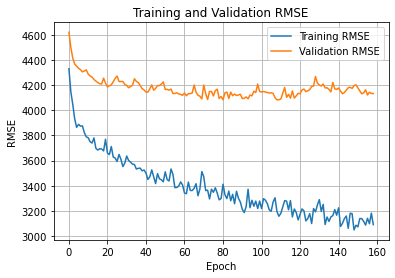

In [12]:
plot_model_history(history, 'ft_transformer_1_root_mean_squared_error', new_data_metrics,'RMSE')

In [16]:
model_reload = tf.keras.models.load_model(MODEL_SAVE_DIR)

In [17]:
test_df = df_to_dataset(downstream_test_df[FEATURES], shuffle=False, batch_size=1)
predict_results = model_reload.predict(test_df)
y_pred = predict_results['output'].ravel()
modis_compare_data = get_modis_compare_data(y_pred)
get_all_metrics(y_pred, modis_compare_data[TARGET_FEATURE], downstream_test_df[TARGET_FEATURE])

/home/zheng.yant/ML-LUE/fttransformer/utils/preprocessing.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]


156/156 [==============================] - 2s 9ms/step
RMSE prediction: 3760.3045
RMSE MOD17: 4553.6565
R-Squared prediction: 0.660331134625151
R-Squared MOD17: 0.5018842973195095
Max error prediction: 11849.962453125001
Max error MOD17: 15912.398000000001
Mean poisson deviance prediction: 1211.8268374592437
Mean poisson deviance MOD17: 1798.8400467873778
Mean gamma deviance prediction: 0.14518373642523288
Mean gamma deviance MOD17: 0.2386320768239554
Mean pinball loss with alpha = 0.9 prediction: 1562.0972423314806
Mean pinball loss with alpha = 0.9 MOD17: 2446.825938601763
Mean pinball loss with alpha = 0.09999999999999998 prediction: 1228.2488206067208
Mean pinball loss with alpha = 0.09999999999999998 MOD17: 946.820942608173


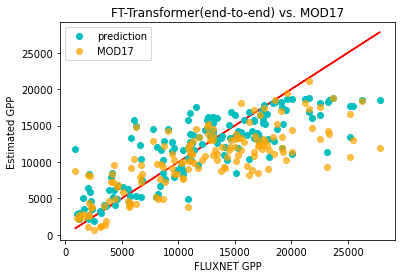

In [18]:
plot_result_distribution(downstream_test_df[TARGET_FEATURE], y_pred, modis_compare_data[TARGET_FEATURE], save_dir=f'{MODEL_RESULT_PLT_DIR}FT-Transformer_e2e.png', title='FT-Transformer(end-to-end) vs. MOD17')